In [1]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 42.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 16.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 42.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
from pathlib import Path 
from typing import Optional, Callable
import matplotlib.pyplot as plt
import rasterio
from fastai.vision.all import *
import skimage.io as skio
import torch
from torch.utils.data import Dataset
import cv2
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import timm
import torchgeo
from torchgeo.models import CROMA
from torchgeo.models.croma import load_weights,CROMABase_Weights, croma_base
from torchvision.models._api import Weights, WeightsEnum

from lightning.pytorch import LightningModule, Trainer, seed_everything, Callback, LightningDataModule
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import  WeightedRandomSampler
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Dataset Class

In [4]:
class S2Disease(Dataset):
    def __init__(self, root_dir,
                 is_eval=False,
                 transform=None,
                 target_size = (120,120)
                ):
        """
        Args:
            root_dir (str): rootman
            is_eval (bool): If True, loads only from 'evaluation'. If False, loads diseases.
            transform (callable, optional): PyTorch transforms.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.is_eval = is_eval
        self.target_size = target_size
        
        self.bands = [
            'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 
            'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'
        ]

        # Create a mapping from band name to index for plotting
        self.band_to_idx = {name: i for i, name in enumerate(self.bands)}
        
        if is_eval:
            self.samples = list((self.root_dir / "evaluation").glob("*/"))
            # We still need the class list to know the vector size for one-hot encoding
            # assuming the structure is consistent. 
            # Ideally, pass the class list from the training set.
            self.classes = ['Aphid', 'Blast', 'RPH', 'Rust'] 
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        else:
            all_dirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
            self.classes = sorted([d.name for d in all_dirs if d.name != "evaluation"])
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
            self.samples = []
            for cls in self.classes:
                self.samples.extend(list((self.root_dir / cls).glob("*/")))

        self.idx_to_class = {v:k for k,v in self.class_to_idx.items()}
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = self.samples[idx]

        ## target size
        target_size = self.target_size
        
        # Load spectral bands
        band_data = []
        for band in self.bands:
            band_file = sample_path / f"{band}.tif"
            with rasterio.open(band_file) as src:
                data = src.read(1).astype(np.float32)
                
                # Check if resize is needed
                if data.shape != target_size:
                    # cv2.resize expects (width, height), which is (columns, rows)
                    data = cv2.resize(data, target_size, interpolation=cv2.INTER_LINEAR)
                
                band_data.append(data)
        
        # Stack into (Channels, Height, Width)
        image = np.stack(band_data)
        
        # Determine Label
        if self.is_eval:
            # For evaluation, return a dummy zero vector of the same shape
            one_hot_label = torch.zeros(self.num_classes)
        else:
            class_name = sample_path.parent.name
            label_idx = self.class_to_idx[class_name]
            # Create one-hot vector: [1, 0, 0, 0]
            one_hot_label = torch.zeros(self.num_classes)
            one_hot_label[label_idx] = 1.0
        
        sample = {
            'image': torch.from_numpy(image),
            'label': one_hot_label,
            'sample_id': sample_path.name # Useful for Kaggle submission tracking
        }

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

    def plot(self, 
             sample: dict, 
             bands: list[str] = ['B4', 'B3', 'B2'], 
             figsize: tuple = (8, 8),
             suptitle: str = None) -> Figure:
            """
            Plots chosen bands. If 3 bands provided, plots RGB. If 1, plots grayscale.
            """
            img_tensor = sample['image']
            plot_data = []
    
            #index mapping
            for b in bands:
                idx = self.band_to_idx[b]
                band_array = img_tensor[idx].numpy()
                
                # clip to the 2nd and 98th percentile
                vmin, vmax = np.percentile(band_array, (2, 98))
                band_array = np.clip((band_array - vmin) / (vmax - vmin + 1e-8), 0, 1)
                plot_data.append(band_array)

            fig, ax = plt.subplots(figsize=figsize)
    
            if len(bands) == 3:
                # (H, W, 3) for RGB
                rgb_img = np.stack(plot_data, axis=-1)
                ax.imshow(rgb_img)
                ax.set_title(f"RGB Composite: {bands}")
            else:
                # Plot single band (grayscale)
                ax.imshow(plot_data[0], cmap='gray')
                ax.set_title(f"Single Band: {bands[0]}")
    
            ax.axis('off')
            
            if suptitle:
                plt.suptitle(suptitle)
            elif not self.is_eval:
                class_number = int(np.argmax(sample['label'].cpu().byte().numpy()))
                class_name = self.idx_to_class[class_number]
                plt.suptitle(f"Class: {class_name} | ID: {sample['sample_id']}")
    
            return fig

### create the dataset class object

In [5]:
dataset = S2Disease( root_dir = "/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")
                    
                    # "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")

In [6]:
len(dataset)

900

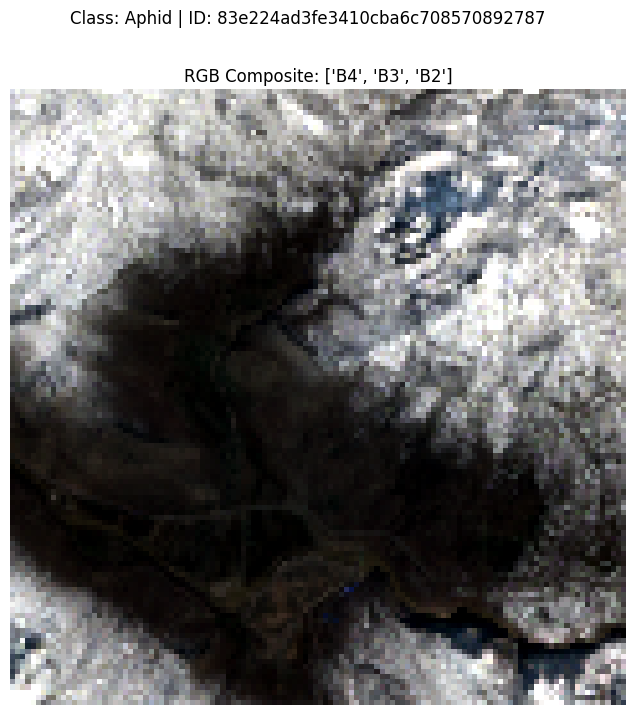

In [7]:
fig = dataset.plot(dataset.__getitem__(30))

In [8]:
imgg = dataset.__getitem__(30)
imgg

{'image': tensor([[[ 7063.0000,  7076.8999,  7178.8335,  ...,  5460.9165,
            5568.3501,  5583.0000],
          [ 7042.2998,  7056.7974,  7163.1128,  ...,  5511.4331,
            5619.6001,  5634.3501],
          [ 6890.5000,  6909.3794,  7047.8267,  ...,  5881.8887,
            5995.4336,  6010.9165],
          ...,
          [ 7454.4165,  7465.6040,  7547.6460,  ...,  3601.3472,
            3443.3750,  3421.8333],
          [ 8307.6504,  8302.8320,  8267.5049,  ...,  3408.1750,
            3237.5649,  3214.3000],
          [ 8424.0000,  8417.0000,  8365.6670,  ...,  3381.8333,
            3209.5000,  3186.0000]],
 
         [[ 7796.8799,  8193.6006,  7582.7998,  ...,  5196.2002,
            6060.1602,  5232.7998],
          [ 6557.2002,  7829.7603,  6819.3999,  ...,  5879.7998,
            5459.8799,  4627.7998],
          [ 7327.6001,  6756.6001,  8688.0000,  ...,  6820.0000,
            6961.6001,  6505.2002],
          ...,
          [ 9108.7998, 11114.4004, 10032.0000,  .

## DataModule Class

In [9]:
dataset.samples[0].parent.name

'Aphid'

In [10]:
dataset.class_to_idx['Aphid']

0

In [11]:
from torch.utils.data import Subset
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------------------------------
# TransformSubset otimizado para CROMA + Sentinel-2
# -------------------------------
class TransformSubset(Subset):
    """Subset com suporte a transformações, escala correta e labels compatíveis com CROMA"""
    
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform
    
    def __getitem__(self, idx):
        # Pegar item do Subset
        sample = super().__getitem__(idx)
        
        # Extrair image e label
        image = sample['image']          # Tensor [C,H,W]
        label = sample['label']          # one-hot ou outro formato
        
        # Escala para 0-1 (reflectância Sentinel-2 crua)
        image = image.float() / 10000.0
        
        # Converter label one-hot para índice se necessário
        if len(label.shape) > 0 and label.shape[0] > 1:
            label = torch.tensor(label).argmax()
        else:
            label = torch.tensor(label).long()
        
        # Converter para numpy H,W,C para aplicar Albumentations
        image_np = image.permute(1,2,0).cpu().numpy()
        
        # Aplicar transform se existir
        if self.transform:
            augmented = self.transform(image=image_np)
            image = augmented['image']   # Tensor [C,H,W]
        else:
            # Se não tiver transform, converte de volta para tensor
            image = torch.from_numpy(image_np).permute(2,0,1).float()
        
        return image, label


In [12]:

class S2DiseaseDataModule(LightningDataModule):
    def __init__(
        self,
        root_dir: str,
        batch_size: int = 16,
        num_workers: int = 4,
        train_val_test_split: tuple[float, float, float] = (0.8, 0.1, 0.1),
        transforms: Optional[Callable] = None,
        seed: int = 42,
        use_weighted_sampler = True
    ):
        super().__init__()
        self.save_hyperparameters()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_val_test_split = train_val_test_split
        self.transforms = transforms
        self.seed = seed
        self.use_weighted_sampler = use_weighted_sampler
        
        # Datasets placeholders
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.predict_dataset = None

    def _stratified_split(self, dataset):
        """
        Perform stratified split to ensure each class is proportionally 
        represented in train, val, and test sets.
        This avoid random split to skip one of the diseases classes.
        """
        #extract class labels for each sample
        labels = []
        for sample_path in dataset.samples:
            class_name = sample_path.parent.name
            labels.append(dataset.class_to_idx[class_name])
        
        labels = np.array(labels)
        indices = np.arange(len(dataset))
        
        train_ratio, val_ratio, test_ratio = self.train_val_test_split
        
        #split1: separate out test set
        train_val_indices, test_indices = train_test_split(
            indices,
            test_size=test_ratio,
            stratify=labels,
            random_state=self.seed
        )
        
        #split2: separate train and val from the remaining data
        # Adjust val_ratio relative to the remaining data
        val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
        
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_ratio_adjusted,
            stratify=labels[train_val_indices],
            random_state=self.seed
        )
        
        return train_indices, val_indices, test_indices

    def _get_sample_weights(self, dataset, indices):
        """Calculate sample weights for WeightedRandomSampler"""
        # Count samples per class
        class_counts = {}
        for idx in indices:
            sample_path = dataset.samples[idx]
            class_name = sample_path.parent.name
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        # Calculate weight for each sample
        sample_weights = []
        for idx in indices:
            sample_path = dataset.samples[idx]
            class_name = sample_path.parent.name
            # Weight is inverse of class frequency
            weight = 1.0 / class_counts[class_name]
            sample_weights.append(weight)
        
        return sample_weights

    
    def get_class_weights(self, method='inverse'):
        """
        Calculate class weights for handling imbalanced dataset.
        
        Args:
            method: 'inverse', 'inverse_sqrt', or 'effective_samples'
        
        Returns:
            List of weights for each class [Aphid, Blast, RPH, Rust]
        """
        # Load dataset to count samples
        full_dataset = S2Disease(
            root_dir=self.root_dir,
            is_eval=False,
            transform=None
        )
        
        # Count samples per class
        class_counts = {}
        for sample_path in full_dataset.samples:
            class_name = sample_path.parent.name
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        # Sort by class index to ensure correct order
        counts = [class_counts[cls] for cls in full_dataset.classes]
        total_samples = sum(counts)
        
        if method == 'inverse':
            # Inverse frequency: weight = total / count
            weights = [total_samples / count for count in counts]
        
        elif method == 'inverse_sqrt':
            # Smoother version: weight = sqrt(total / count)
            weights = [np.sqrt(total_samples / count) for count in counts]
        
        elif method == 'effective_samples':
            # Effective number of samples (from paper: https://arxiv.org/abs/1901.05555)
            beta = 0.9999
            effective_num = [1.0 - np.power(beta, count) for count in counts]
            weights = [(1.0 - beta) / en for en in effective_num]
        
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Normalize weights so they sum to num_classes
        weights = np.array(weights)
        weights = weights / weights.sum() * len(weights)
        
        print("\n" + "="*50)
        print("Class Weights")
        print("="*50)
        for cls, count, weight in zip(full_dataset.classes, counts, weights):
            print(f"{cls:<15} Count: {count:<5} Weight: {weight:.4f}")
        print("="*50 + "\n")
        
        return weights.tolist()
         
    def setup(self, stage: Optional[str] = None):
        """Set up datasets based on the stage (fit, test, predict)."""
        if stage == "fit" or stage == "test" or stage is None:
            #labeled dataset (Aphid, Blast, RPH, Rust)
            full_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=False,
                transform=self.transforms
            )
            
            # Perform stratified split
            train_indices, val_indices, test_indices = self._stratified_split(full_dataset)
            
            # Create subset datasets
            
            # self.train_dataset = Subset(train_dataset_full, train_indices)
            # self.val_dataset   = Subset(val_dataset_full, val_indices)

            # train_subset = Subset(full_dataset, train_indices)
            # print('subset', train_subset)
            # val_subset = Subset(full_dataset, val_indices)
            # self.test_dataset = Subset(full_dataset, test_indices)
            # # self.train_dataset = Subset(full_dataset, train_indices, transform=train_transform)
            # # self.val_dataset = Subset(full_dataset, val_indices)

            # self.train_dataset = TransformSubset(train_subset, transform=train_transform)
            # print('train_dataset', self.train_dataset)
            # self.val_dataset = TransformSubset(val_subset, transform=val_transform)
            
            # self.train_dataset = Subset(train_dataset_full, train_indices)
            # self.val_dataset   = Subset(val_dataset_full, val_indices)
            self.train_dataset = TransformSubset(
                full_dataset,      # ← dataset diretamente
                train_indices,     # ← índices diretamente
                transform=train_transform
            )
            
            self.val_dataset = TransformSubset(
                full_dataset,
                val_indices,
                transform=val_transform
            )
            
            self.test_dataset = TransformSubset(
                full_dataset,
                test_indices,
                transform=None
            )
                        #Print split statistics for verification
            self._print_split_statistics(full_dataset, train_indices, val_indices, test_indices)
        
        if stage == "predict":
            # Load from the 'evaluation' folder
            self.predict_dataset = S2Disease(
                root_dir=self.root_dir,
                is_eval=True,
                transform=self.transforms
            )

    def _print_split_statistics(self, dataset, train_idx, val_idx, test_idx):
        """Print class distribution across splits for verification."""
        def get_class_counts(indices):
            class_counts = {cls: 0 for cls in dataset.classes}
            for idx in indices:
                sample_path = dataset.samples[idx]
                class_name = sample_path.parent.name
                class_counts[class_name] += 1
            return class_counts
        
        print("\n" + "="*50)
        print("Dataset Split Statistics")
        print("="*50)
        
        train_counts = get_class_counts(train_idx)
        val_counts = get_class_counts(val_idx)
        test_counts = get_class_counts(test_idx)
        
        print(f"\n{'Class':<15} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
        print("-"*55)
        
        for cls in dataset.classes:
            total = train_counts[cls] + val_counts[cls] + test_counts[cls]
            print(f"{cls:<15} {train_counts[cls]:<10} {val_counts[cls]:<10} "
                  f"{test_counts[cls]:<10} {total:<10}")
        
        print("-"*55)
        print(f"{'TOTAL':<15} {len(train_idx):<10} {len(val_idx):<10} "
              f"{len(test_idx):<10} {len(dataset):<10}")
        print("="*50 + "\n")

    def train_dataloader(self):
        if self.use_weighted_sampler:
            # Get the underlying dataset (if it's a Subset)
            if isinstance(self.train_dataset, Subset):
                base_dataset = self.train_dataset.dataset
                indices = self.train_dataset.indices
            else:
                base_dataset = self.train_dataset
                indices = list(range(len(base_dataset)))
            
            # Calculate sample weights
            sample_weights = self._get_sample_weights(base_dataset, indices)
            
            # Create weighted sampler
            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights),
                replacement=True
            )

            return DataLoader(
                    self.train_dataset,
                    batch_size=self.batch_size,
                    sampler=sampler,  # Use sampler instead of shuffle
                    num_workers=self.num_workers,
                    pin_memory=True
                )
        else:
            return DataLoader(
                self.train_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=self.num_workers,
                pin_memory=True
            )
            
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )



In [13]:
datamodule = S2DiseaseDataModule("/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")
datamodule.get_class_weights(method='inverse')


Class Weights
Aphid           Count: 290   Weight: 0.3149
Blast           Count: 75    Weight: 1.2176
RPH             Count: 495   Weight: 0.1845
Rust            Count: 40    Weight: 2.2830



[0.31489801598345984,
 1.2176056618027116,
 0.18448570633374417,
 2.2830106158800842]

## Backbone

-- CROMA

In [15]:
## CROMA Instance
## BACKBONE 
## Create model 
croma_backbone = CROMA(
    modalities = ["optical"],
    encoder_dim = 768,
        encoder_depth = 12,
        num_heads  = 16,
        patch_size  = 8,
        image_size = 120
    )

## load weights 
load_weights(croma_backbone, CROMABase_Weights.CROMA_VIT)




Downloading: "https://hf.co/torchgeo/croma/resolve/387883f08af79d777167519c57cd826eda89a16f/CROMA_base-0238d814.pt" to /root/.cache/torch/hub/checkpoints/CROMA_base-0238d814.pt


100%|██████████| 742M/742M [00:02<00:00, 347MB/s] 


In [16]:
## FOCAL LOSS
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    Paper: https://arxiv.org/abs/1708.02002
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha: Class weights (list or tensor)
            gamma: Focusing parameter (higher = more focus on hard examples)
            reduction: 'mean' or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (N, C) logits
            targets: (N,) class indices
        """
        ce_loss = F.cross_entropy(inputs,
                                  targets,
                                  reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [17]:

class SentinelDiseaseClassifier(LightningModule):
    def __init__(self,
                 croma_backbone,
                 num_classes=4,
                 hidden_dim=512,
                 learning_rate = 1e-3,
                 weight_decay=1e-4,
                 class_weights = None,
                 use_focal_loss=True,
                 focal_gamma=2.0,
                    freeze=True
                ):
        super(SentinelDiseaseClassifier, self).__init__()
        self.save_hyperparameters(ignore = ['croma_backbone'])

        
        #encoder 
        self.encoder = croma_backbone

        ## Freeze backbone parameters
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.encoder.eval()
        
        # DECODER
        # CROMA encoder_dim is 768
        self.decoder = nn.Sequential(
            nn.Linear(768, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

        # Loss function
        if class_weights is not None:
            class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
            # Register as buffer so it moves with the model to GPU/CPU automatically
            self.register_buffer('class_weights', class_weights_tensor)
            
        if use_focal_loss:
            self.criterion = FocalLoss(alpha=class_weights, gamma=focal_gamma)
        else:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        
        ## METRICS
        # Use balanced accuracy and weighted F1
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes, average='macro')
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes, average='macro')
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes, average='macro')
        
        self.train_f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        
        # Per-class metrics for monitoring
        self.val_f1_per_class = F1Score(task="multiclass", num_classes=num_classes, average=None)
        self.val_precision_per_class = Precision(task="multiclass", num_classes=num_classes, average=None)
        self.val_recall_per_class = Recall(task="multiclass", num_classes=num_classes, average=None)
    
        # Optional: Per-class F1 scores for detailed analysis
        self.val_f1_per_class = F1Score(
            task="multiclass", 
            num_classes=num_classes, 
            average=None
        )
        
    def forward(self, x_optical):
        # Forward pass -  CROMA
        outputs = self.encoder(x_optical=x_optical)

        ## CROMA output two dict:
        ## dict_keys(['optical_encodings', 'optical_GAP'])
        ## For the first test we are using the GAP (Global Average Pool)
        # Shape: [batch_size, 768]
        gap_features = outputs['optical_GAP']
        
        # Forward through decoder
        logits = self.decoder(gap_features)
        
        return logits

    def training_step(self, batch, batch_idx):
        """Training step"""
        images = batch['image'] ## b, 12, 120, 120 
        labels = batch['label'] ## one hot encoder [b, 4] [1,0,0,0]

        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)  # [batch] with values 0-3

        # Forward pass
        logits = self(images)

        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions (argmax of logits)
        preds = torch.argmax(logits, dim=1)

        ##### DEBUG
        if batch_idx == 0:
            # We use [0] to select only the first image in the batch
            first_label = label_indices[0].detach().cpu().numpy()
            first_logit = logits[0].detach().cpu().numpy()
            
            # For BCEWithLogitsLoss, we apply sigmoid to see probabilities (0.0 to 1.0)
            first_probs = torch.sigmoid(logits[0]).detach().cpu().numpy()
            
            # If it's multi-label, we usually threshold at 0.5 instead of argmax
            first_pred_multi = (first_probs > 0.5).astype(int)
            
            # If it's single-label (one-hot), argmax is still useful
            first_pred_idx = torch.argmax(logits[0]).detach().cpu().item()
        
            print(f"batch idx:{batch_idx} ---")
            print(f"True Label Vector: {first_label}")
            print(f"Raw Logits:        {first_logit}")
            print(f"Probabilities:     {first_probs}")
            print(f"Predicted Class:   {first_pred_idx}")
            print(f"Batch Loss:        {loss.item():.4f}")
            
        # Calculate metrics
        acc = self.train_accuracy(preds, label_indices)
        f1 = self.train_f1(preds, label_indices)
        
        # Log metrics
        # Get the actual batch size from the input tensor
        current_batch_size = images.shape[0]
        self.log('train/loss', loss, on_step=True, on_epoch=True,
                 prog_bar=True,
                 batch_size=current_batch_size)
        self.log('train/acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train/f1', f1, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step"""
        images = batch['image']
        labels = batch['label']
        
        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)
        
        # Forward pass
        logits = self(images)
        
        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate metrics
        acc = self.val_accuracy(preds, label_indices)
        f1 = self.val_f1(preds, label_indices)
        f1_per_class = self.val_f1_per_class(preds, label_indices)
        
        # Log metrics
        self.log('val/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/f1', f1, on_step=False, on_epoch=True, prog_bar=True)
        
        # Log per-class F1 scores
        class_names = ['Aphid', 'Blast', 'RPH', 'Rust']
        for i, class_name in enumerate(class_names):
            self.log(f'val/f1_{class_name}', f1_per_class[i], on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        """Test step"""
        images = batch['image']
        labels = batch['label']
        
        # Convert one-hot to class indices
        label_indices = torch.argmax(labels, dim=1)
        
        # Forward pass
        logits = self(images)
        
        # Calculate loss
        loss = self.criterion(logits, label_indices)
        
        # Get predictions
        preds = torch.argmax(logits, dim=1)
        
        # Calculate metrics
        acc = self.test_accuracy(preds, label_indices)
        f1 = self.test_f1(preds, label_indices)
        
        # Log metrics
        self.log('test/loss', loss, on_step=False, on_epoch=True)
        self.log('test/acc', acc, on_step=False, on_epoch=True)
        self.log('test/f1', f1, on_step=False, on_epoch=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        """Prediction step for inference on evaluation set"""
        images = batch['image']
        sample_ids = batch['sample_id']
        
        # Forward pass
        logits = self(images)
        
        # Get probabilities using softmax
        probs = torch.softmax(logits, dim=1)
        
        # Get predicted class (argmax of probabilities)
        predicted_classes = torch.argmax(probs, dim=1)
        
        return {
            'sample_id': sample_ids,
            'predictions': predicted_classes,
            'probabilities': probs
        }
    
    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val/loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }
    
    def on_train_epoch_end(self):
        """Called at the end of training epoch"""
        # Metrics are automatically reset by torchmetrics
        pass
    
    def on_validation_epoch_end(self):
        """Called at the end of validation epoch"""
        # Metrics are automatically reset by torchmetrics
        pass

# TRAIN - TEST 

### Add wandb tracker 

In [18]:
# from kaggle_secrets import UserSecretsClient
# import wandb

# # Get the secret from Kaggle
# user_secrets = UserSecretsClient()
# wandb_key = user_secrets.get_secret("wandb")

# #  Set the environment variable so WandB doesn't try to "write" a file
# os.environ["WANDB_API_KEY"] = wandb_key

# #login now works without needing to write to the filesystem
# wandb.login()

In [19]:
# from datetime import datetime
# # Initialize WandB logger
# wandb_logger = WandbLogger(
#     project="sentinel-disease-classification",
#     name="croma-classifier-run"
# )

In [20]:
## BACKBONE 
## Create model 
croma_backbone = CROMA(
    modalities = ["optical"],
    encoder_dim = 768,
        encoder_depth = 12,
        num_heads  = 16,
        patch_size  = 8,
        image_size = 120
    )

## load weights for backbone 
load_weights(croma_backbone, CROMABase_Weights.CROMA_VIT)

In [24]:
train_transform = A.Compose([
    
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    A.Affine(
        translate_percent={"x": 0.03, "y": 0.03},  # shift 
        scale=(0.97, 1.03),                        
        rotate=(-5, 5),                           
        mode=0,
        p=0.5
    ),

    A.GaussNoise(var_limit=(2.0, 8.0), p=0.1),

    ToTensorV2()
])

val_transform = A.Compose([
    ToTensorV2()
])


/tmp/ipykernel_55/2433935342.py:8: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(
/tmp/ipykernel_55/2433935342.py:17: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(2.0, 8.0), p=0.1),


In [25]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="train/loss",    # métrica que será monitorada (val_loss ou val_acc)
    min_delta=0.000,         # mínima melhoria considerada como progresso
    patience=8,            # número de epochs sem melhora antes de parar
    verbose=True,
    mode="min"             # "min" porque queremos que val_loss diminua
)

In [26]:

## Finish any existing wandb run before starting a new one
# if wandb.run is not None:
#     wandb.finish()

## Create unique run name with timestamp
timestamp = datetime.now().strftime("%d_%H%M")

## SETUP Variables
epochs = 50
lr = 1e-3
batch_size = 16
hidden_dim = 512 ##hidden dimension of the decoder
name_of_run = f"S2DI_{epochs}-{batch_size}-{lr}-{timestamp}"

# wandb_logger = WandbLogger(
#     log_model = 'all',
#     project="sen2-disease-crops",
#     name=name_of_run,
#     reinit=True ##force new run
# )

## seed
seed_everything(42, workers=True)

# Initialize DataModule
datamodule = S2DiseaseDataModule(
    root_dir="/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle",
    batch_size=batch_size,
    num_workers=4,
    train_val_test_split=(0.8, 0.1, 0.1),
    seed=42
)

## Initialize the backbone 

## Get weights for unbalanced ds
weights = datamodule.get_class_weights(method='inverse')
weights_tensor = torch.tensor(weights).to('cuda')

# Initialize model
model = SentinelDiseaseClassifier(
    croma_backbone=croma_backbone, 
    num_classes=4,
    hidden_dim=hidden_dim,
    freeze=True,
    learning_rate= lr,
    weight_decay=1e-4,
    class_weights= weights_tensor,  # Pass weights
    use_focal_loss=True,  # Use Focal Loss
    focal_gamma=2.0
)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val/f1',  # Updated metric name
    mode='max',
    save_top_k=3,
    dirpath='checkpoints/',
    filename='disease-classifier-{epoch:02d}-{val/loss:.4f}-{val/f1:.4f}',
    save_last=True
)

# Train
trainer = Trainer(
    # logger=wandb_logger,
    max_epochs=epochs,
    accelerator='gpu',
    devices=1,
    precision='16-mixed',
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Fit the model
trainer.fit(model, datamodule=datamodule)

# Validate
trainer.validate(model=model, datamodule=datamodule)

# Test
trainer.test(model=model, datamodule=datamodule)

# Predict on evaluation set
##predictions = trainer.predict(model=model, datamodule=datamodule)

Seed set to 42
/tmp/ipykernel_55/1588073881.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



Class Weights
Aphid           Count: 290   Weight: 0.3149
Blast           Count: 75    Weight: 1.2176
RPH             Count: 495   Weight: 0.1845
Rust            Count: 40    Weight: 2.2830



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Dataset Split Statistics

Class           Train      Val        Test       Total     
-------------------------------------------------------
Aphid           232        29         29         290       
Blast           60         7          8          75        
RPH             396        50         49         495       
Rust            32         4          4          40        
-------------------------------------------------------
TOTAL           720        90         90         900       



/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃    ┃ Name                    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0  │ encoder                 │ CROMA               │ 90.3 M │ eval  │     0 │
│ 1  │ decoder                 │ Sequential          │  396 K │ train │     0 │
│ 2  │ criterion               │ FocalLoss           │      0 │ train │     0 │
│ 3  │ train_accuracy          │ MulticlassAccuracy  │      0 │ train │     0 │
│ 4  │ val_accuracy            │ MulticlassAccuracy  │      0 │ train │     0 │
│ 5  │ test_accuracy           │ MulticlassAccuracy  │      0 │ train │     0 │
│ 6  │ train_f1                │ MulticlassF1Score   │      0 │ train │     0 │
│ 7  │ val_f1                  │ MulticlassF1Score   │      0 │ train │     0 │
│ 8  │ test_f1                 │ MulticlassF1Score   │      0 │ train │     0 │
│ 9  │ val_f1_per_class        │ MulticlassF1Score   │      0 │ train │     0 │
│ 10 │ val_precision_per_class │ MulticlassPrecision │      0 │ train │     0 │
│ 11 │ val_recall_per_class    │ MulticlassRecall    │      0 │ train │     0 │
└────┴─────────────────────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 396 K                                                                                            
Non-trainable params: 90.3 M                                                                                       
Total params: 90.7 M                                                                                               
Total estimated model params size (MB): 362                                                                        
Modules in train mode: 16                                                                                          
Modules in eval mode: 167                                                                                          
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:534: Found 167 module(s) in eval mode 
at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can 
ignore this warning.

batch idx:0 ---

True Label Vector: 0

Raw Logits:        [ 0.1456  0.874  -0.6304 -0.7817]

Probabilities:     [0.536  0.7056 0.3474 0.314 ]

Predicted Class:   1

Batch Loss:        1.3237

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

Metric train/loss improved. New best score: 0.295


batch idx:0 ---

True Label Vector: 0

Raw Logits:        [-0.6504 -1.101  -3.037   2.71  ]

Probabilities:     [0.343   0.2496  0.04578 0.9375 ]

Predicted Class:   3

Batch Loss:        0.0938

Metric train/loss improved by 0.144 >= min_delta = 0.0. New best score: 0.152


batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-1.358   1.3    -0.3923 -1.758 ]

Probabilities:     [0.2045 0.7856 0.403  0.1471]

Predicted Class:   1

Batch Loss:        0.1589

Metric train/loss improved by 0.053 >= min_delta = 0.0. New best score: 0.099


batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-3.615   2.309  -0.1256 -1.56  ]

Probabilities:     [0.0262 0.9097 0.4688 0.1737]

Predicted Class:   1

Batch Loss:        0.0590

Metric train/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.087


batch idx:0 ---

True Label Vector: 3

Raw Logits:        [-0.2637 -1.453  -2.215   1.835 ]

Probabilities:     [0.4346  0.1896  0.09845 0.8623 ]

Predicted Class:   3

Batch Loss:        0.1326

Metric train/loss improved by 0.018 >= min_delta = 0.0. New best score: 0.069


batch idx:0 ---

True Label Vector: 3

Raw Logits:        [-0.11566 -2.25    -3.457    1.535  ]

Probabilities:     [0.4712  0.09534 0.03056 0.8228 ]

Predicted Class:   3

Batch Loss:        0.1705

Metric train/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.061


batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-0.612  -0.594  -1.388   0.4155]

Probabilities:     [0.3516 0.3557 0.1998 0.6025]

Predicted Class:   3

Batch Loss:        0.0427

batch idx:0 ---

True Label Vector: 0

Raw Logits:        [ 0.8096 -2.37   -2.58    2.285 ]

Probabilities:     [0.692   0.0856  0.07043 0.9077 ]

Predicted Class:   3

Batch Loss:        0.0429

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [-1.007 -1.396 -2.947  1.985]

Probabilities:     [0.2676  0.1984  0.04987 0.8794 ]

Predicted Class:   3

Batch Loss:        0.0440

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-1.315  0.506 -1.275 -1.593]

Probabilities:     [0.2115 0.624  0.2184 0.169 ]

Predicted Class:   1

Batch Loss:        0.0345

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 0.2217 -2.535  -3.668   2.957 ]

Probabilities:     [0.555   0.0734  0.02489 0.9507 ]

Predicted Class:   3

Batch Loss:        0.0281

batch idx:0 ---

True Label Vector: 0

Raw Logits:        [ 0.9995 -3.518  -3.97    3.154 ]

Probabilities:     [0.731   0.02881 0.01851 0.959  ]

Predicted Class:   3

Batch Loss:        0.1683

batch idx:0 ---

True Label Vector: 0

Raw Logits:        [ 0.8936 -1.79   -2.967   1.405 ]

Probabilities:     [0.7095  0.1431  0.04895 0.803  ]

Predicted Class:   3

Batch Loss:        0.2486

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [-1.73  -1.747 -2.65   2.102]

Probabilities:     [0.1505 0.1484 0.066  0.891 ]

Predicted Class:   3

Batch Loss:        0.0281

Metric train/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.056


batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-2.184  1.476 -0.756 -1.121]

Probabilities:     [0.10126 0.814   0.3196  0.2458 ]

Predicted Class:   1

Batch Loss:        0.0791

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-1.862  2.39   1.306 -2.379]

Probabilities:     [0.1344 0.916  0.7866 0.0848]

Predicted Class:   1

Batch Loss:        0.0689

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-4.13   3.48   1.117 -4.566]

Probabilities:     [0.01584 0.97    0.7534  0.01029]

Predicted Class:   1

Batch Loss:        0.0594

Metric train/loss improved by 0.009 >= min_delta = 0.0. New best score: 0.047


batch idx:0 ---

True Label Vector: 0

Raw Logits:        [ 0.3613 -2.797  -3.38    1.918 ]

Probabilities:     [0.5894 0.0575 0.0329 0.872 ]

Predicted Class:   3

Batch Loss:        0.0427

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-2.654   2.38   -0.1715 -3.111 ]

Probabilities:     [0.06573 0.9155  0.4573  0.04263]

Predicted Class:   1

Batch Loss:        0.0434

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-2.863  2.412  0.857 -2.846]

Probabilities:     [0.054  0.918  0.702  0.0549]

Predicted Class:   1

Batch Loss:        0.0327

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-3.596  3.959  1.715 -2.863]

Probabilities:     [0.0267 0.9814 0.8477 0.054 ]

Predicted Class:   1

Batch Loss:        0.0385

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-3.322  4.316  2.18  -4.52 ]

Probabilities:     [0.03482 0.987   0.8984  0.01078]

Predicted Class:   1

Batch Loss:        0.0402

Metric train/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.046


batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-2.984   2.514   0.8403 -2.012 ]

Probabilities:     [0.04813 0.9253  0.6987  0.118  ]

Predicted Class:   1

Batch Loss:        0.0623

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-1.876  3.06   1.879 -5.086]

Probabilities:     [0.1328   0.955    0.8677   0.006145]

Predicted Class:   1

Batch Loss:        0.0276

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-1.809  2.936  1.243 -3.572]

Probabilities:     [0.1409  0.9497  0.776   0.02733]

Predicted Class:   1

Batch Loss:        0.0355

Metric train/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.042


batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 2.117 -5.473 -5.43   3.553]

Probabilities:     [0.8926   0.00418  0.004364 0.972   ]

Predicted Class:   3

Batch Loss:        0.0679

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 1.104 -2.63  -3.96   2.588]

Probabilities:     [0.751   0.0672  0.01869 0.93   ]

Predicted Class:   3

Batch Loss:        0.0275

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-3.078   2.959   0.1736 -4.234 ]

Probabilities:     [0.044   0.9507  0.5435  0.01428]

Predicted Class:   1

Batch Loss:        0.0958

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-0.649   -0.04605 -1.535   -0.573  ]

Probabilities:     [0.3433 0.4885 0.1772 0.3606]

Predicted Class:   1

Batch Loss:        0.0216

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 2.268 -6.74  -7.35   4.906]

Probabilities:     [9.0625e-01 1.1835e-03 6.4135e-04 9.9268e-01]

Predicted Class:   3

Batch Loss:        0.0145

Metric train/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.034


batch idx:0 ---

True Label Vector: 0

Raw Logits:        [-0.159  -0.1289 -1.819  -1.568 ]

Probabilities:     [0.4602 0.4678 0.1395 0.1725]

Predicted Class:   1

Batch Loss:        0.0284

batch idx:0 ---

True Label Vector: 0

Raw Logits:        [-0.4067  0.1218 -1.071  -1.3   ]

Probabilities:     [0.3997 0.5303 0.2551 0.2142]

Predicted Class:   1

Batch Loss:        0.0272

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 0.6   -2.713 -2.518  1.552]

Probabilities:     [0.6455  0.06223 0.07465 0.825  ]

Predicted Class:   3

Batch Loss:        0.1355

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-4.156    2.83     0.05756 -1.65   ]

Probabilities:     [0.01543 0.9443  0.514   0.161  ]

Predicted Class:   1

Batch Loss:        0.0279

batch idx:0 ---

True Label Vector: 2

Raw Logits:        [-1.596  2.123  1.392 -3.025]

Probabilities:     [0.1686 0.893  0.801  0.0463]

Predicted Class:   1

Batch Loss:        0.0301

batch idx:0 ---

True Label Vector: 3

Raw Logits:        [ 0.2152 -2.947  -3.299   1.791 ]

Probabilities:     [0.5537  0.04987 0.0356  0.857  ]

Predicted Class:   3

Batch Loss:        0.0273

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-1.692  2.625  0.87  -3.184]

Probabilities:     [0.1555 0.9326 0.7046 0.0398]

Predicted Class:   1

Batch Loss:        0.0550

batch idx:0 ---

True Label Vector: 1

Raw Logits:        [-4.656   3.451   1.8955 -4.03  ]

Probabilities:     [0.009415 0.969    0.869    0.01744 ]

Predicted Class:   1

Batch Loss:        0.0324

Monitored metric train/loss did not improve in the last 8 records. Best score: 0.034. Signaling Trainer to stop.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val/acc          │    0.34899473190307617    │
│          val/f1           │    0.16066402196884155    │
│       val/f1_Aphid        │    0.2904761731624603     │
│       val/f1_Blast        │    0.21320901811122894    │
│        val/f1_RPH         │    0.04444444552063942    │
│        val/f1_Rust        │    0.15238095819950104    │
│         val/loss          │    0.08329694718122482    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Dataset Split Statistics

Class           Train      Val        Test       Total     
-------------------------------------------------------
Aphid           232        29         29         290       
Blast           60         7          8          75        
RPH             396        50         49         495       
Rust            32         4          4          40        
-------------------------------------------------------
TOTAL           720        90         90         900       



Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.2991534471511841     │
│          test/f1          │    0.19294613599777222    │
│         test/loss         │    0.05879746377468109    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.05879746377468109,
  'test/acc': 0.2991534471511841,
  'test/f1': 0.19294613599777222}]

In [27]:
train_loader = datamodule.train_dataloader()

for batch in train_loader:
    images = batch['image']
    labels = batch['label']
    print("Batch shape:", images.shape)
    print("Min:", images.min().item())
    print("Max:", images.max().item())
    break


Batch shape: torch.Size([16, 12, 120, 120])
Min: 0.0
Max: 16983.0


In [28]:
torch.tensor(datamodule.get_class_weights(method='inverse'))


Class Weights
Aphid           Count: 290   Weight: 0.3149
Blast           Count: 75    Weight: 1.2176
RPH             Count: 495   Weight: 0.1845
Rust            Count: 40    Weight: 2.2830



tensor([0.3149, 1.2176, 0.1845, 2.2830])

### Prepare CSV

In [30]:
## Prepare a prediction csv for evaluation. 

## dict
dataset = S2Disease(root_dir = "/kaggle/input/competitions//beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle")
dict_idx_to_class = dataset.idx_to_class

##  datamodule
datamodule.predict_dataset = S2Disease(
                root_dir="/kaggle/input/competitions/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle",
                is_eval=True,
            )

## Model in eval mode
model.eval()
model = model.to('cuda')

list_sample_id = []
list_class_name = []
with torch.no_grad():
    for sample in datamodule.predict_dataset:
        tensor = sample['image'].unsqueeze(0).to('cuda')
        sample_id = sample['sample_id']

        ## predict 
        logit = model(tensor)

        ## argmax 
        pred = torch.argmax(logit, dim=1)
        
        ## transform to named category 
        nome_pred = dict_idx_to_class[pred.cpu().numpy()[0]]

        ## append list
        list_sample_id.append(sample_id)
        list_class_name.append(nome_pred)

In [31]:
import pandas as pd

In [32]:
df = pd.DataFrame()
df['Id'] = list_sample_id
df['Category'] = list_class_name

In [33]:
df

,Id,Category
0,994b5409c8e946538d87109a99897659,Blast
1,1a419acc1ecc467897d5477a47353fa8,Blast
2,8662df21b2c94788adce4a885ae2b4dc,Blast
3,a564868c3d8c4d4fabde67a536f178ad,Rust
4,796e611aaf8a4f0db57cb79be058f3ae,Rust
5,e77d3a0965fe46d9b3275a7d7f34dbe2,Blast
6,a39dcd0a21824289bb38b40ddf98da89,Blast
7,e427f07618794fd58dfc9e6c786e3743,Rust
8,13739e32e7a84f669e6ef1284715e93b,Blast
9,b6eeb2bfd281476883fc273b61133e60,Blast
